In [1]:
from transformers import T5Tokenizer
import pandas as pd
import json
import ast
from datasets import list_datasets, load_dataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

C:\Users\nkhozin\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def class_by_len(value):
    if value<=500:
        return 'small'
    elif value<=1000:
        return 'medium'
    elif value<=1500:
        return 'large'
    elif value<=2000:
        return 'big'
    else:
        return 'huge'
    
def del_symbols(value):
    try:
        obj = value[value.find('{'):]
        return json.loads(obj)
    except:
        return 0

def my_json_load(value):
    try:
        obj = json.loads(value)
        return obj
    except:
        obj = del_symbols(value)
        return obj

In [3]:
base = 'C:\\Users\\nkhozin\\Downloads\\jupyter_notebooks\\mfdp\\'

In [4]:
#Посчитаем число токенов взяв токенизатор Т5
tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-base-multitask')

In [5]:
ru_simp_main = pd.read_csv(base+'RuSimpleSentEval-main\\RuSimpleSentEval-main\\dev_sents.csv', index_col=0, on_bad_lines='skip')

ru_simp_test = pd.read_csv(base+'RuSimpleSentEval-main\\RuSimpleSentEval-main\\public_test_sents.csv', index_col=0, on_bad_lines='skip')

ru_simp = pd.concat([ru_simp_main, ru_simp_test], axis=0).rename(columns={'INPUT:source':'source', 'OUTPUT:output':'target'})

print(ru_simp.shape)

(6804, 2)


In [6]:
ru_adapt_lit_1 = pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Adapted_literature\\zlatoust_paragraph_aligned_with_bleualign.csv', on_bad_lines='skip')
ru_adapt_lit_1 = ru_adapt_lit_1[['source','target']]

ru_adapt_lit_2 = pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Adapted_literature\\zlatoust_paragraph_aligned_with_CATS.csv', on_bad_lines='skip')
ru_adapt_lit_2 = ru_adapt_lit_2[['source','target']]

ru_adapt_lit_3 = pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Adapted_literature\\zlatoust_sentence_aligned_with_CATS.csv', on_bad_lines='skip')
ru_adapt_lit_3 = ru_adapt_lit_3[['source','target']]

ru_lit = pd.concat([ru_adapt_lit_1, ru_adapt_lit_2, ru_adapt_lit_3], axis=0)

ru_adapt_enc_1 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_B_to_A_par.csv', on_bad_lines='skip')
ru_adapt_enc_1.target = ru_adapt_enc_1.target.apply(lambda value: value.replace("\n", ""))
ru_adapt_enc_1 = ru_adapt_enc_1[['source','target']]

ru_adapt_enc_2 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_B_to_A_sent.csv', on_bad_lines='skip')
ru_adapt_enc_2 = ru_adapt_enc_2[['source','target']]

ru_adapt_enc_3 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_C_to_A_sent.csv', on_bad_lines='skip')
ru_adapt_enc_3 = ru_adapt_enc_3[['source','target']]

ru_adapt_enc_4 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_B_to_A_sent.csv', on_bad_lines='skip')
ru_adapt_enc_4 = ru_adapt_enc_4[['source','target']]

ru_adapt_enc_5 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_C_to_B_par.csv', on_bad_lines='skip')
ru_adapt_enc_5 = ru_adapt_enc_5[['source','target']]

ru_adapt_enc_6 =  pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Encyclopedic\\lsslovar_C_to_B_sent.csv', on_bad_lines='skip')
ru_adapt_enc_6 = ru_adapt_enc_6[['source','target']]

ru_enc = pd.concat([ru_adapt_enc_1, ru_adapt_enc_2, ru_adapt_enc_3, ru_adapt_enc_4, ru_adapt_enc_5, ru_adapt_enc_6], axis=0)

ru_adapt_fair_1 = pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Fairytales\\df_fairytales_par.csv', on_bad_lines='skip')
ru_adapt_fair_1 = ru_adapt_fair_1[['source','target']]

ru_adapt_fair_2 = pd.read_csv(base+'RuAdapt-main\RuAdapt-main\Fairytales\\df_fairytales_sent.csv', on_bad_lines='skip')
ru_adapt_fair_2 = ru_adapt_fair_2[['source','target']]

ru_fair = pd.concat([ru_adapt_fair_1, ru_adapt_fair_2], axis=0)

ru_adapt = pd.concat([ru_lit, ru_enc, ru_fair], axis=0)

print(ru_adapt.shape)

(52635, 2)


In [7]:
para_phraser = pd.read_json(base+'ParaPhraserPlus\\ParaPhraserPlus\\ParaPhraserPlus.json', orient='index', encoding='utf-8')

para_phraser['source'] = para_phraser.headlines.apply(lambda value: value[1])
para_phraser['target'] = para_phraser.headlines.apply(lambda value: value[0])
para_phraser = para_phraser[['source', 'target']]

print(para_phraser.shape)

(1725393, 2)


In [15]:
with open('data\\russian_XLSum_v2.0\\russian_XLSum_v2.jsonl', 'r', encoding='utf-8-sig') as json_file:
    json_list = list(json_file)
    
ru_xlsum = pd.DataFrame(json_list)
ru_xlsum['json'] = ru_xlsum[0].apply(lambda value: my_json_load(value))
ru_xlsum = ru_xlsum.json.apply(pd.Series)[['id','url','title','summary','text']]
ru_xlsum = ru_xlsum[~ru_xlsum.id.isna()]
ru_xlsum = ru_xlsum.rename(columns={'text':'source', 'summary':'target'})[['source','target']]

print(ru_xlsum.shape)

(77803, 2)


In [16]:
with open('data\\gazeta_jsonl\\gazeta.jsonl', 'r', encoding='utf-8-sig') as json_file:
    json_list = list(json_file)

gazeta = pd.DataFrame(json_list)
gazeta['json'] = gazeta[0].apply(lambda value: my_json_load(value))
gazeta = gazeta.json.apply(pd.Series)[['url','text','title','summary','date']]
gazeta = gazeta[~gazeta.url.isna()]
gazeta = gazeta.rename(columns={'text':'source', 'summary':'target'})[['source','target']]

print(gazeta.shape)

(63435, 2)


In [19]:
ru_simp['type'] = 'ru_simp'
ru_adapt['type'] = 'ru_adapt'
para_phraser['type'] = 'para_phraser'
ru_xlsum['type'] = 'ru_xlsum'
gazeta['type'] = 'gazeta'

In [20]:
data = pd.concat([ru_simp, ru_adapt, para_phraser, ru_xlsum, gazeta], axis=0)

In [21]:
data.head(3)

,source,target,type
3,14 декабря 1944 года рабочий посёлок Ички был ...,14 декабря 1944 года рабочий посёлок Ички пере...,ru_simp
4,1960 году была выпущена модель 172A. Изменени...,В 1960 году вышла модель 172А. Отличие в хвост...,ru_simp
5,1960 году была выпущена модель 172A. Изменени...,В выпущенной в 1960 году модель имела изменени...,ru_simp


In [22]:
#
data.source = data.source.apply(lambda value: f'simplify | {value}')

In [23]:
%%time

data['source_len'] = data['source'].apply(lambda value: len(tokenizer.tokenize(value)))
data['target_len'] = data['target'].apply(lambda value: len(tokenizer.tokenize(value)))

CPU times: total: 7min 2s
Wall time: 7min 2s


In [24]:
data['size'] = data.source_len.apply(class_by_len)

In [30]:
data.groupby(['type','size'], as_index=False).agg({
    'source_len':['count','min','max','mean'],
    'target_len':['min','max','mean']
    })

type    size source_len                           target_len       \
                              count   min    max         mean        min  max   
0         gazeta     big      21879  1301   1800  1485.276795         22  167   
1         gazeta    huge       7661  1801   2841  2105.275551         25  172   
2         gazeta   large      31527   801   1300  1127.017921         25  168   
3         gazeta  medium       2342   401    800   710.594791         26  158   
4         gazeta   small         26    41    397   287.615385         28  123   
5   para_phraser    huge          1  5663   5663  5663.000000         15   15   
6   para_phraser  medium          1   480    480   480.000000        366  366   
7   para_phraser   small    1725391     4    265    22.019769          1  225   
8       ru_adapt     big         36  1308   1773  1571.944444         23  815   
9       ru_adapt    huge         33  1852   8180  4565.454545         22  949   
10      ru_adapt   large        121   803   1291   988.991736         10  824   
11      ru_adapt  medium        477   401    799   547.716981          5  719   
12      ru_adapt   small      51968     4    400    48.394204          1  610   
13       ru_simp   small       6804    16    168    42.263081          2  140   
14      ru_xlsum     big      10289  1301   1800  1533.510545          4  214   
15      ru_xlsum    huge      15493  1801  37904  2870.528690          0  463   
16      ru_xlsum   large      15233   801   1300  1028.943215          2  279   
17      ru_xlsum  medium      18987   401    800   592.887239          7  158   
18      ru_xlsum   small      17801    32    400   233.437560          3  154   

                
          mean  
0    95.298505  
1    98.886046  
2    88.606718  
3    76.649018  
4    72.192308  
5    15.000000  
6   366.000000  
7    19.108705  
8   203.416667  
9   324.727273  
10  211.057851  
11  189.364780  
12   34.063808  
13   27.052469  
14   59.824473  
15   64.887368  
16   56.365128  
17   50.816875  
18   44.719173

In [27]:
data.groupby('type', as_index=False).agg({
    'source_len':['count','min','max','mean'],
    'target_len':['count','min','max','mean']
    })

type source_len                         target_len           \
                     count min    max         mean      count min  max   
0        gazeta      63435  41   2841  1353.008150      63435  22  172   
1  para_phraser    1725393   4   5663    22.023304    1725393   1  366   
2      ru_adapt      52635   4   8180    58.955619      52635   1  949   
3       ru_simp       6804  16    168    42.263081       6804   2  140   
4      ru_xlsum      77803  32  37904  1173.963151      77803   0  463   

              
        mean  
0  91.707969  
1  19.108903  
2  36.176157  
3  27.052469  
4  54.501112

In [ ]:
#Уберем сэмплы, где в исходном предложении меньше 10 токенов
#А в целевом меньше 5
#Также уберем, где целевое предложение больше по количеству токенов чем исходное

In [51]:
data = data[data.source_len>=10]
data = data[data.target_len>=5]
data = data[data.source_len>data.target_len]

In [53]:
data.groupby(['type','size'], as_index=False).agg({
    'source_len':['count','min','max','mean'],
    'target_len':['min','max','mean']
    })

type    size source_len                           target_len       \
                              count   min    max         mean        min  max   
0         gazeta     big      21879  1301   1800  1485.276795         22  167   
1         gazeta    huge       7661  1801   2841  2105.275551         25  172   
2         gazeta   large      31527   801   1300  1127.017921         25  168   
3         gazeta  medium       2342   401    800   710.594791         26  158   
4         gazeta   small         25   106    397   297.480000         28  123   
5   para_phraser    huge          1  5663   5663  5663.000000         15   15   
6   para_phraser  medium          1   480    480   480.000000        366  366   
7   para_phraser   small    1143156    10    265    23.584983          5  225   
8       ru_adapt     big         36  1308   1773  1571.944444         23  815   
9       ru_adapt    huge         33  1852   8180  4565.454545         22  949   
10      ru_adapt   large        121   803   1291   988.991736         10  824   
11      ru_adapt  medium        473   401    799   548.490486          5  719   
12      ru_adapt   small      40900    10    400    54.767848          5  393   
13       ru_simp   small       6432    16    168    42.426306          5  140   
14      ru_xlsum     big      10272  1301   1800  1533.506425          5  214   
15      ru_xlsum    huge      15487  1801  37904  2869.034674          5  463   
16      ru_xlsum   large      15224   801   1300  1028.865344          6  279   
17      ru_xlsum  medium      18987   401    800   592.887239          7  158   
18      ru_xlsum   small      17799    32    400   233.428507          9  154   

                
          mean  
0    95.298505  
1    98.886046  
2    88.606718  
3    76.649018  
4    71.920000  
5    15.000000  
6   366.000000  
7    16.816335  
8   203.416667  
9   324.727273  
10  211.057851  
11  186.809725  
12   35.014279  
13   26.127954  
14   59.916861  
15   64.911345  
16   56.396217  
17   50.816875  
18   44.723861

In [52]:
data.groupby('type', as_index=False).agg({
    'source_len':['count','min','max','mean'],
    'target_len':['count','min','max','mean']
    })

type source_len                          target_len           \
                     count  min    max         mean      count min  max   
0        gazeta      63434  106   2841  1353.028833      63434  22  172   
1  para_phraser    1143158   10   5663    23.590316    1143158   5  366   
2      ru_adapt      41563   10   8180    68.001804      41563   5  949   
3       ru_simp       6432   16    168    42.426306       6432   5  140   
4      ru_xlsum      77769   32  37904  1173.479253      77769   5  463   

              
        mean  
0  91.708169  
1  16.816639  
2  37.630152  
3  26.127954  
4  54.523319

In [89]:
data['part'] = (data.target_len/data.source_len*100)

<Axes: xlabel='part', ylabel='Count'>

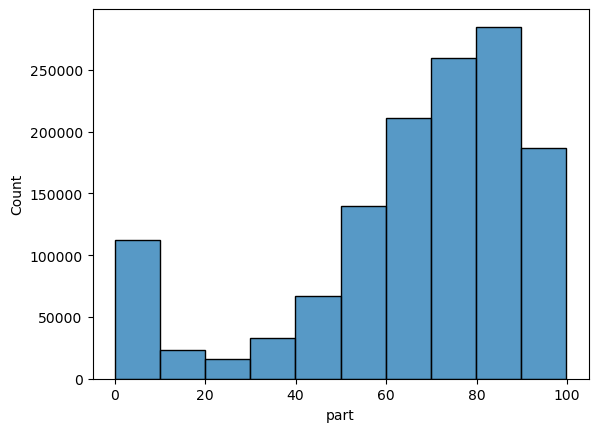

In [91]:
sns.histplot(data['part'], bins=10)

In [93]:
data.groupby(['type'], as_index=False).agg({
    'part':['count','mean','max','min']
    })

type     part                                
                   count       mean        max       min
0        gazeta    63434   7.153975  66.981132  1.086502
1  para_phraser  1143158  72.850433  98.591549  0.264877
2      ru_adapt    41563  69.703642  99.781182  0.659670
3       ru_simp     6432  62.352205  98.437500  9.615385
4      ru_xlsum    77769   9.329042  60.465116  0.074041

In [ ]:
#Из para_phraser уберем тексты, где в целевом содержится менее 20 и более 80 процентов от исходного текста

In [122]:
data['mark'] = np.where((data['type']=='para_phraser')&((data.part<20)|(data.part>80)),1,0)
data = data[data.mark!=1]

In [124]:
data.groupby(['type','size'], as_index=False).agg({
    'source_len':['count','min','max','mean'],
    'target_len':['min','max','mean']
    })

type    size source_len                           target_len       \
                              count   min    max         mean        min  max   
0         gazeta     big      21879  1301   1800  1485.276795         22  167   
1         gazeta    huge       7661  1801   2841  2105.275551         25  172   
2         gazeta   large      31527   801   1300  1127.017921         25  168   
3         gazeta  medium       2342   401    800   710.594791         26  158   
4         gazeta   small         25   106    397   297.480000         28  123   
5   para_phraser  medium          1   480    480   480.000000        366  366   
6   para_phraser   small     715771    10    148    24.637229          5   90   
7       ru_adapt     big         36  1308   1773  1571.944444         23  815   
8       ru_adapt    huge         33  1852   8180  4565.454545         22  949   
9       ru_adapt   large        121   803   1291   988.991736         10  824   
10      ru_adapt  medium        473   401    799   548.490486          5  719   
11      ru_adapt   small      40900    10    400    54.767848          5  393   
12       ru_simp   small       6432    16    168    42.426306          5  140   
13      ru_xlsum     big      10272  1301   1800  1533.506425          5  214   
14      ru_xlsum    huge      15487  1801  37904  2869.034674          5  463   
15      ru_xlsum   large      15224   801   1300  1028.865344          6  279   
16      ru_xlsum  medium      18987   401    800   592.887239          7  158   
17      ru_xlsum   small      17799    32    400   233.428507          9  154   

                
          mean  
0    95.298505  
1    98.886046  
2    88.606718  
3    76.649018  
4    71.920000  
5   366.000000  
6    15.405054  
7   203.416667  
8   324.727273  
9   211.057851  
10  186.809725  
11   35.014279  
12   26.127954  
13   59.916861  
14   64.911345  
15   56.396217  
16   50.816875  
17   44.723861

In [129]:
# Разделение данных на тренировочный и оставшиеся данные
val_data, remaining_data = train_test_split(data, train_size=26400, random_state=42, stratify=data['type'])

In [137]:
types_list = ['para_phraser', 'ru_xlsum', 'ru_adapt', 'ru_simp']

data['mark'] = np.where((data['type'].isin(types_list))&(data['size']=='small'),1,0)

C:\Users\nkhozin\AppData\Local\Temp\ipykernel_10808\1472293634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mark'] = np.where((data['type'].isin(types_list))&(data['size']=='small'),1,0)


In [139]:
small_data = data[data.mark==1]
other_data = data[data.mark!=1]

In [196]:
train = pd.DataFrame()
train_small = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

train_small = pd.DataFrame()
eval_small = pd.DataFrame()

for i in types_list:
    subdata = small_data[small_data['type']==i]
    subdata_train, subdata_test = train_test_split(subdata, test_size=6400, random_state=42)
    subdata_train_small, subdata_test_small = train_test_split(subdata_test, test_size=5120, random_state=42)
    subdata_eval, subdata_test = train_test_split(subdata_train_small, test_size=640, random_state=42)
    
    train = pd.concat([train, subdata_train], axis=0)
    train_small = pd.concat([train_small, subdata_test_small], axis=0)
    val = pd.concat([val, subdata_eval], axis=0)
    test = pd.concat([test, subdata_test], axis=0)

In [206]:
print(len(train))
print(len(train_small))
print(len(val))
print(len(test))

879370
20480
2560
2560


In [202]:
train = pd.concat([train, other_data], axis=0)

In [203]:
train['size'].value_counts()

small     755327
large      46872
big        32187
huge       23181
medium     21803
Name: size, dtype: int64

In [207]:
train.sample(frac=1).to_csv('train.csv')
train_small.sample(frac=1).to_csv('train_small.csv')
val.sample(frac=1).to_csv('eval.csv')
test.sample(frac=1).to_csv('test.csv')